In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib

import matplotlib
from scipy.ndimage import gaussian_filter1d

/home/users/yandanw/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning:

Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function



In [2]:
from time import time
import sys
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import psutil
#from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
#import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
%matplotlib inline

In [3]:
from scipy.interpolate import interp1d as interp1d

In [ ]:
######## create and save directory ##########
# save_path = os.path.join(func_path,'figs','20220905d')
# os.mkdir(save_path)

In [36]:
func_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_311/func_0/'

In [37]:
# func_path_1 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_261/func_0/'
# func_path_2 = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_262/func_0/'

In [38]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior)
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)

fictrac['h'] = np.rad2deg(fictrac['h'])

def extract_traces(fictrac, stim_times, pre_window, post_window, behavior='Z'):
    traces = []
    for i in range(len(stim_times)):
        trace = fictrac[behavior][stim_times[i]-pre_window:stim_times[i]+post_window]
        if len(trace) == pre_window + post_window: # this handles fictrac that crashed or was aborted or some bullshit
            traces.append(trace)
    traces = np.asarray(traces)
    mean_trace = np.mean(traces,axis=0)
    sem_trace = scipy.stats.sem(traces,axis=0)
    return traces, mean_trace, sem_trace

loading photodiode data... done


In [39]:
#######################
### Load Neural Data###
#######################
neural_file = os.path.join(func_path, 'functional_channel_2_moco_zscore_highpass.h5') #
with h5py.File(neural_file, 'r') as h:
    print(h['data'].shape)
    neural = h['data'][:]

(256, 128, 49, 3384)


In [40]:
#################
### Supervox ###
#################
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)
print(all_signals.shape)
# all_signals -> analysis -> supervoxel_to_full_rex -> exploded brain

(49, 2000, 3384)


In [41]:
#################
### Supervox ###
#################
all_signals.shape

timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))

fixed = brainsss.load_fda_meanbrain()

atlas = brainsss.load_roi_atlas()

explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

def supervoxel_to_full_res(brain, cluster_labels):
    n_clusters = brain.shape[1]
    
    reformed_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = brain[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        reformed_brain.append(colored_by_betas)
    return np.asarray(reformed_brain)


Trying to load timestamp data from hdf5 file.
Success.


In [42]:
heading = fictrac['h']
heading = heading%360

In [10]:
##################################################################
### Downsample the 100Hz fictrac data to 3384 neual data frame ###
##################################################################
timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
fictrac_timestamps = np.arange(0,1800000,10)

def interpolate_to_neural(slice_num, timestamps):
    x = timestamps[:, slice_num]
    f = interp1d(fictrac_timestamps, heading, fill_value="extrapolate") 
    ynew = f(x)
    return ynew

fwd = fictrac['Y']
def interpolate_to_neural_fwd(slice_num, timestamps):
    x = timestamps[:, slice_num]
    f = interp1d(fictrac_timestamps, fwd, fill_value="extrapolate") 
    ynew = f(x)
    return ynew

ang = fictrac['Z']
def interpolate_to_neural_ang(slice_num, timestamps):
    x = timestamps[:, slice_num]
    f = interp1d(fictrac_timestamps, ang, fill_value="extrapolate") 
    ynew = f(x)
    return ynew

heading_interpolated = interpolate_to_neural(0,timestamps)
### redefine 0
heading_interpolated -= 180
fwd_interpolated = interpolate_to_neural_fwd(0,timestamps)
ang_interpolated = interpolate_to_neural_ang(0,timestamps)



Trying to load timestamp data from hdf5 file.
Success.


In [11]:
# Define cluster boundaries
fixation_range = [(0,20),(340,360)]
away_ranges = [(160, 220)]
stop_fwd_threshold = 0.5
stop_ang_threshold = 10

# Initialize empty arrays for each cluster
pre_fixation = []
fixation =[]
pre_away =[]
away = []
rest = []
pause = []
others = []

# Loop through each angle and categorize it
for t, angle in enumerate(heading_interpolated.flatten()):
    if angle >= 160 and angle <= 220:
        if np.abs(fwd_interpolated[t])>stop_fwd_threshold or np.abs(ang_interpolated[t])>stop_ang_threshold:
            pre_away.append(t)
        else:
            pause.append(t)            
    elif angle >= 0 and angle <= 20:
        if np.abs(fwd_interpolated[t])>stop_fwd_threshold or np.abs(ang_interpolated[t])>stop_ang_threshold:
            pre_fixation.append(t)
        else:
            pause.append(t)
    elif angle >= 340 and angle <= 360:
        if np.abs(fwd_interpolated[t])>stop_fwd_threshold or np.abs(ang_interpolated[t])>stop_ang_threshold:
            pre_fixation.append(t)
        else:
            pause.append(t)
    else:
        rest.append(t)

pre_fixation_angles = [heading_interpolated.flatten()[t] for t in pre_fixation]
pre_fixation_angles = np.asarray(pre_fixation_angles)


for t in pre_fixation:
    duration = heading_interpolated[pre_fixation[t:t+1]]
    if duration.size > 0:
        if np.max(duration) - np.min(duration) <= 40:
            fixation.append(t)
        else:
            others.append(t) 
for t in pre_away:
    duration = heading_interpolated[pre_away[t:t+1]]
    if duration.size > 0:
        if np.max(duration) - np.min(duration) <= 40:
            away.append(t)
        else:
            others.append(t) 

pre_menotaxis = []
menotaxis = []

for t in rest:
    if np.abs(fwd_interpolated[t])<stop_fwd_threshold and np.abs(ang_interpolated[t])<stop_ang_threshold:
        pause.append(t)
    else:
        pre_menotaxis.append(t)
        
for t in pre_menotaxis:
    duration = heading_interpolated[pre_menotaxis[t:t+10]]
    if duration.size > 0:
        if np.max(duration) - np.min(duration) <= 40:
            menotaxis.append(t)
        else:
            others.append(t)

sleep = []
for t in pause:
    fwd_d = fwd_interpolated[t:t+40]
    ang_d = np.unwrap(ang_interpolated[t:t+40])
    if np.max(fwd_d)-np.min(fwd_d) < stop_fwd_threshold and np.max(ang_d)-np.min(ang_d) < stop_ang_threshold:
        sleep.append(t)
    else:
        others.append(t)
print(f"Fixation: {len(fixation)}")
print(f"Away: {len(away)}")
print(f"Menotaxis: {len(menotaxis)}")
print(f"Pause: {len(pause)}")
print(f"Sleep: {len(sleep)}")
print(f"Others: {len(others)}")
print(f"Sum: {len(fixation)+len(away)+len(others)+len(pause)+len(menotaxis)}")

Fixation: 0
Away: 0
Menotaxis: 8
Pause: 1734
Sleep: 6
Others: 2152
Sum: 3894


In [11]:
# Define cluster boundaries
fixation_range = (-20, 20)
away_ranges = [(-180, -160), (160, 180)]
stop_fwd_threshold = 0.5
stop_ang_threshold = 10

# Initialize empty arrays for each cluster
fixation = []
away = []
rest = []
pause = []

# Loop through each angle and categorize it
for t, angle in enumerate(heading_interpolated.flatten()):
    if angle >= fixation_range[0] and angle <= fixation_range[1]:
        if np.abs(fwd_interpolated[t])>stop_fwd_threshold or np.abs(ang_interpolated[t])>stop_ang_threshold:
            fixation.append(t)
        else:
            pause.append(t)
    elif angle >= away_ranges[0][0] and angle <= away_ranges[0][1]:
        if np.abs(fwd_interpolated[t])>stop_fwd_threshold or np.abs(ang_interpolated[t])>stop_ang_threshold:
            away.append(t)
        else:
            pause.append(t)
    elif angle >= away_ranges[1][0] and angle <= away_ranges[1][1]:
        if np.abs(fwd_interpolated[t])>stop_fwd_threshold or np.abs(ang_interpolated[t])>stop_ang_threshold:
            away.append(t)
        else:
            pause.append(t)
    else:
        rest.append(t)

# Print the number of angles in each cluster
# print(f"Fixation: {len(fixation)}")
# print(f"Away: {len(away)}")
# print(f"Rest: {len(rest)}")
# print(f"Pause: {len(pause)}")
# fixation, away, stop, and menotaxis are list of t (idex number in 3384)

pre_menotaxis = []
menotaxis = []
others = []
for t in rest:
    if np.abs(fwd_interpolated[t])<stop_fwd_threshold and np.abs(ang_interpolated[t])<stop_ang_threshold:
        pause.append(t)
    else:
        pre_menotaxis.append(t)
# print(f"Pause: {len(pause)}")
# print(f"pre_menotaxis: {len(pre_menotaxis)}")

pre_menotaxis_angles = [heading_interpolated.flatten()[t] for t in pre_menotaxis]
pre_menotaxis_angles = np.asarray(pre_menotaxis_angles)

for t, angle in enumerate(pre_menotaxis_angles.flatten()):
    duration = pre_menotaxis_angles.flatten()[t:t+10] 
    # the fly needs to stabilize the bar within a range of 40 degrees for at least 5s, which is 10 imaging time units
    if np.max(duration) - np.min(duration) <= 40:
        menotaxis.append(t)
    else:
        others.append(t)
# print(f"menotaxis: {len(menotaxis)}")
# print(f"others: {len(others)}")

print(f"Fixation: {len(fixation)}")
print(f"Away: {len(away)}")
print(f"Others: {len(others)}")
print(f"Pause: {len(pause)}")
print(f"Menotaxis: {len(menotaxis)}")
print(f"Sum: {len(fixation)+len(away)+len(others)+len(pause)+len(menotaxis)}")

Fixation: 258
Away: 111
Others: 1570
Pause: 1394
Menotaxis: 51
Sum: 3384


In [12]:
pause_angles = [heading_interpolated.flatten()[t] for t in pause]
pause_angles = np.asarray(pause_angles)
sleep = []
for t, angle in enumerate(pause_angles.flatten()):
    fwd_d = fwd_interpolated[t:t+9]
    ang_d = np.unwrap(ang_interpolated[t:t+9])
    if np.max(fwd_d)-np.min(fwd_d) < stop_fwd_threshold and np.max(ang_d)-np.min(ang_d) < stop_ang_threshold:
        sleep.append(t)
    else:
        others.append(t)
print(f"Sleep: {len(sleep)}")
print(f"Others: {len(others)}")
print(f"Pause: {len(pause)}")
print(f"Sum: {len(sleep)+len(others)}")

Sleep: 34
Others: 2930
Pause: 1394
Sum: 2964


In [112]:
#pause_angles

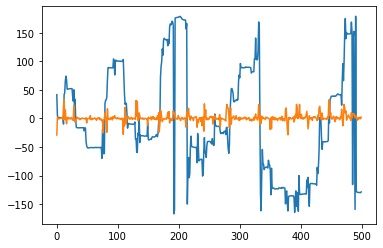

In [12]:
plt.plot(heading_interpolated[1000:1500])
plt.plot((fwd_interpolated *10)[1000:1500])

In [82]:
#rest_angles = [heading_interpolated.flatten()[t] for t in rest]

In [83]:
#rest_angles = np.asarray(rest_angles)

In [81]:
#stop = []
pre_menotaxis = []
menotaxis = []
others = []
for t in rest:
    if np.abs(fwd_interpolated[t])<stop_fwd_threshold and np.abs(ang_interpolated[t])<stop_ang_threshold:
        pause.append(t)
    else:
        pre_menotaxis.append(t)
print(f"Pause: {len(pause)}")
print(f"pre_menotaxis: {len(pre_menotaxis)}")

Pause: 430
pre_menotaxis: 2426


In [86]:
pre_menotaxis_angles = [heading_interpolated.flatten()[t] for t in pre_menotaxis]
pre_menotaxis_angles = np.asarray(pre_menotaxis_angles)

In [87]:
np.shape(pre_menotaxis_angles )

(2426,)

In [89]:
for t, angle in enumerate(pre_menotaxis_angles.flatten()):
    duration = pre_menotaxis_angles.flatten()[t:t+10]
    if np.max(duration) - np.min(duration) <= 40:
        menotaxis.append(t)
    else:
        others.append(t)
print(f"menotaxis: {len(menotaxis)}")
print(f"others: {len(others)}")
#print(f"Pause: {len(pause)}")

menotaxis: 53
others: 2373


In [88]:
2373+53

2426

In [92]:
print(f"Fixation: {len(fixation)}")
print(f"Away: {len(away)}")
print(f"Others: {len(others)}")
print(f"Pause: {len(pause)}")
print(f"Menotaxis: {len(menotaxis)}")

Fixation: 342
Away: 186
Others: 2373
Pause: 430
Menotaxis: 53


In [65]:
print(f"rest: {len(rest)}")
print(f"pre_menotaxis: {len(pre_menotaxis)}")
print(f"Pause: {len(pause)}")

rest: 2759
pre_menotaxis: 2426
Pause: 430


In [50]:
pause_angles = [heading_interpolated.flatten()[t] for t in pause]
pause_angles = np.asarray(pause_angles)
for t, angle in enumerate(pause_angles.flatten()):

In [13]:
print(f"stop angles: {len(stop)}") 
print(f"menotaxis angles: {len(menotaxis)}") 

stop angles: 333
menotaxis angles: 2426


In [28]:
342 + 186 + 2759 + 97

3384

In [29]:
1800/3384

0.5319148936170213

In [26]:
heading_interpolated.flatten().size

3384

In [29]:
################
### Supervox ###
################
neural_supvox = supervoxel_to_full_res(neural, cluster_labels)

ValueError: shape mismatch: value array of shape (49,3384) could not be broadcast to indexing result of shape (64,)

In [25]:
warps = brainsss.warp_STA_brain(STA_brain=np.rollaxis(all_slices,3,0), fly='fly_262', fixed=fixed, anat_to_mean_type='myr')

NameError: name 'all_slices' is not defined

In [15]:
cluster_labels.shape

(49, 32768)

In [16]:
np.shape(heading)

(180000,)

(array([12955., 15642., 16029., 19931., 18032., 18058., 21406., 24118.,
        19966., 13863.]),
 array([3.96434126e-03, 3.60012817e+01, 7.19985991e+01, 1.07995917e+02,
        1.43993234e+02, 1.79990551e+02, 2.15987869e+02, 2.51985186e+02,
        2.87982503e+02, 3.23979821e+02, 3.59977138e+02]),
 <BarContainer object of 10 artists>)

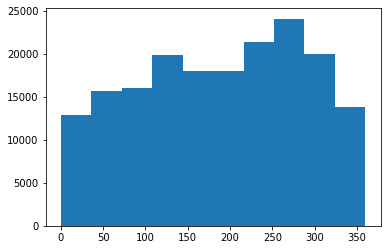

In [17]:
plt.hist(heading)

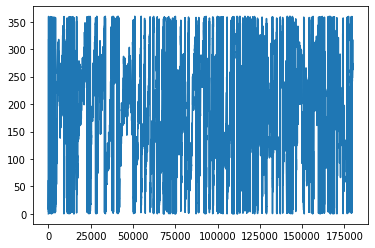

In [18]:
plt.plot(heading)

(array([2.3000e+02, 2.7210e+03, 1.3585e+04, 3.8403e+04, 8.5144e+04,
        2.8750e+04, 9.1630e+03, 1.7970e+03, 1.8300e+02, 2.4000e+01]),
 array([-456.7929129 , -354.49126537, -252.18961784, -149.88797031,
         -47.58632278,   54.71532475,  157.01697227,  259.3186198 ,
         361.62026733,  463.92191486,  566.22356239]),
 <BarContainer object of 10 artists>)

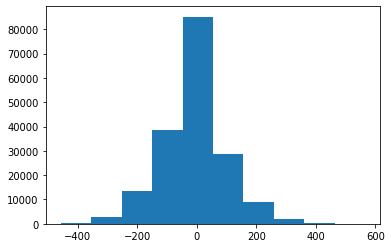

In [19]:
plt.hist(ang)

(array([1.50000e+01, 2.33000e+02, 2.38700e+03, 1.99190e+04, 1.00521e+05,
        4.31070e+04, 1.16050e+04, 1.98600e+03, 1.86000e+02, 4.10000e+01]),
 array([-9.7861203 , -7.57681958, -5.36751885, -3.15821813, -0.94891741,
         1.26038332,  3.46968404,  5.67898476,  7.88828549, 10.09758621,
        12.30688693]),
 <BarContainer object of 10 artists>)

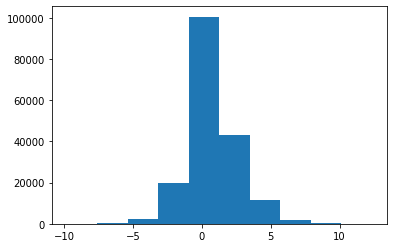

In [20]:
plt.hist(fwd)

In [20]:
heading.shape

(180000,)

In [61]:
type(np.asarray(rest))

numpy.ndarray

In [33]:
fwd_interpolated

array([ 0.98554773, -0.08954537,  1.68006987, ..., -0.45290446,
        2.09552939,  2.20998079])

In [121]:
rest_angles = [heading_interpolated.flatten()[t] for t in rest]
#rest_angles

In [36]:
stop = np.asarray(stop)

In [ ]:
# Fixation: 342
# Away: 186
# Others: 2373
# Pause: 430
# Sleep: 0
# Menotaxis: 53
# Sum: 3384

In [16]:
sleep_neural = neural[:,:,:,sleep]

In [17]:
sleep_average = sleep_neural.mean(axis = -1)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning:

Mean of empty slice.

/home/users/yandanw/.local/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning:

invalid value encountered in true_divide



In [18]:
pause_neural = neural[:,:,:,pause]

In [19]:
pause_average = pause_neural.mean(axis = -1)

In [13]:
### neural correlates for fixation ###
fixation_neural = neural[:,:,:,fixation]

In [28]:
np.shape(fixation_neural)

(256, 128, 49, 14)

In [14]:
### neural correlates for walking away ###
away_neural = neural[:,:,:,away]

In [15]:
### neural correlates for menotaxi ###
meno_neural = neural[:,:,:,menotaxis]

In [21]:
### neural correlates for stop ###
stop_neural = neural[:,:,:,others]

In [ ]:
nav_correlates = {'fix':[], 'away':[], 'meno':[], 'other':[]}
for f in flies:
    fix, away, meno, other = get_neural_correlates_for_navigation(fly_path)
    nav_correlates.['fix'].append(fix)
    # repeat for away, meno, other

# {'fix':[fly1_matrix, fly2_matrix, ...], }
    
nav_correlates['fix'] = np.stack(nav_correlates['fix'], axis=-1) # shape (256, 128, 49, (#fixation_fly0 + #fixation_fly1, ...)
# repeat    

In [ ]:
nav_correlates = {'fix':[], 'escape':[], 'meno':[], 'pause':[], 'other':[]}
for f in flies:
    fix = f.neural[:,:,:,fixation]
    nav_correlates.['fix'].append(fix)
    escape = f.neural[:,:,:,away]
    nav_correlates.['escape'].append(escape)
    meno = f.neural[:,:,:,menotaxis]
    nav_correlates.['meno'].append(meno)
    pause = f.neural[:,:,:,pause]
    nav_correlates.['pause'].append(pause)
    other = f.neural[:,:,:,others]
    nav_correlates.['other'].append(other)
nav_correlates['fix'] = np.stack(nav_correlates['fix'], axis=-1)    
nav_correlates['escape'] = np.stack(nav_correlates['escape'], axis=-1)
nav_correlates['meno'] = np.stack(nav_correlates['meno'], axis=-1)
nav_correlates['pause'] = np.stack(nav_correlates['pause'], axis=-1)
nav_correlates['other'] = np.stack(nav_correlates['other'], axis=-1)  

In [21]:
fixation_average = fixation_neural.mean(axis = -1)
away_average = away_neural.mean(axis = -1)
meno_average = meno_neural.mean(axis = -1)
#others_average = stop_neural.mean(axis = -1)

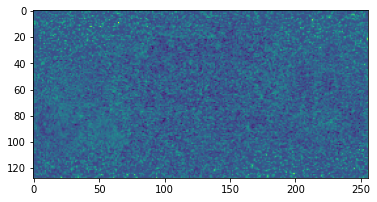

In [23]:
# sleep: 10
z = 30
plt.imshow(sleep_average[:,:,z].T)

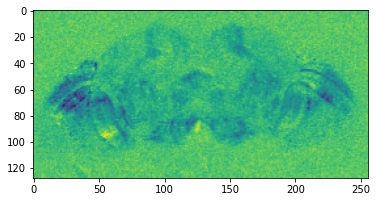

In [24]:
# Pause: 430
z = 17
plt.imshow(pause_average[:,:,z].T)

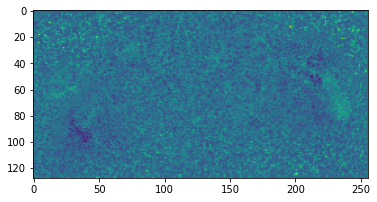

In [23]:
# Fixation: 342
z = 25
plt.imshow(fixation_average[:,:,z].T)

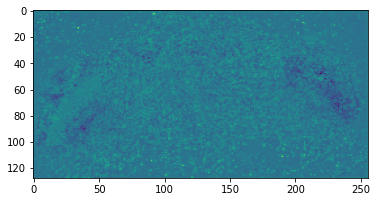

In [25]:
# Away: 186
z = 25
plt.imshow(away_average[:,:,z].T)

In [29]:
np.shape(away_average)

(256, 128, 49)

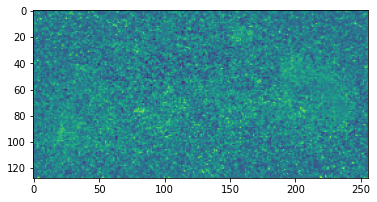

In [27]:
# Menotaxis: 53
z = 25
plt.imshow(meno_average[:,:,z].T)

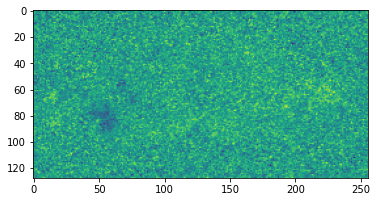

In [29]:
# Others: 2373
z = 17
plt.imshow(others_average[:,:,z].T)

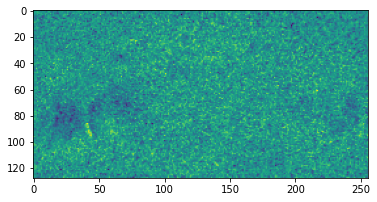

In [30]:
z = 28
fixation_average = fixation_neural.mean(axis = -1)
away_average = away_neural.mean(axis = -1)
plt.imshow(fixation_average[:,:,z].T - away_average[:,:,z].T)

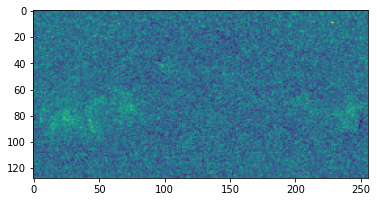

In [31]:
z = 25
fixation_average = fixation_neural.mean(axis = -1)
away_average = away_neural.mean(axis = -1)
plt.imshow(away_average[:,:,z].T - fixation_average[:,:,z].T)

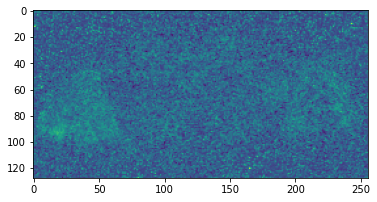

In [32]:
plt.imshow(meno_average[:,:,z].T - pause_average[:,:,z].T)

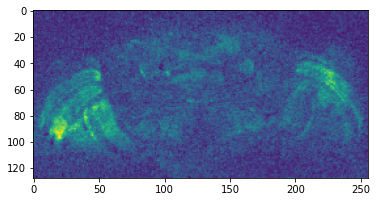

In [33]:
plt.imshow(fixation_average[:,:,z].T - pause_average[:,:,z].T)

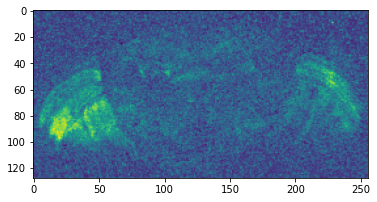

In [34]:
plt.imshow(away_average[:,:,z].T - pause_average[:,:,z].T)

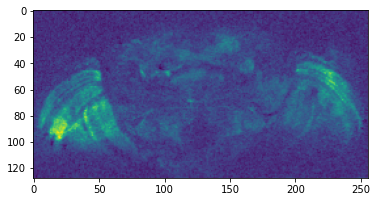

In [36]:
plt.imshow(others_average[:,:,z].T - pause_average[:,:,z].T)

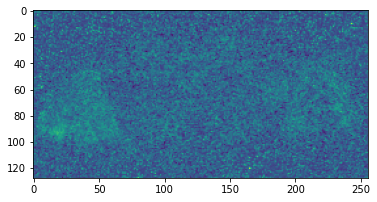

In [35]:
plt.imshow(meno_average[:,:,z].T - pause_average[:,:,z].T)

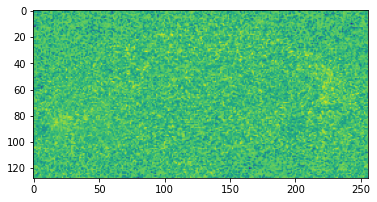

In [37]:
plt.imshow(others_average[:,:,z].T - meno_average[:,:,z].T)

In [34]:
time_unit = np.zeros (3384)
for i in fixation:
    time_unit[i] = 1
for i in away:
    time_unit[i] = 2
for i in menotaxis:
    time_unit[i] = 3
for i in stop:
    time_unit[i] =4

In [35]:
time_unit.shape

(3384,)

In [36]:
import seaborn as sns
import scipy.cluster.hierarchy as sch

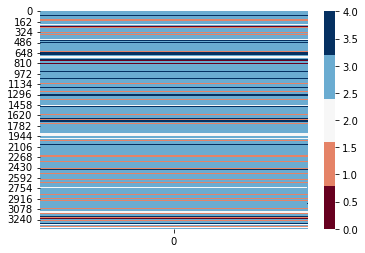

In [37]:
cmap = plt.cm.get_cmap("RdBu", 5)
time_unit_reshape = time_unit.reshape(-1,1)
# Create a heatmap of the data using the "viridis" colormap
sns.heatmap(time_unit_reshape, cmap=cmap)

# Display the heatmap
plt.show()

In [53]:
unique, counts_500 = np.unique(time_unit_500_reshape, return_counts=True)

# Print the unique elements and their counts
for i in range(len(unique)):
    print(f"{unique[i]}: {counts_500[i]}")

0.0: 21
1.0: 61
2.0: 35
3.0: 353
4.0: 30


In [182]:
counts_500

array([ 80,  47, 326,  47])

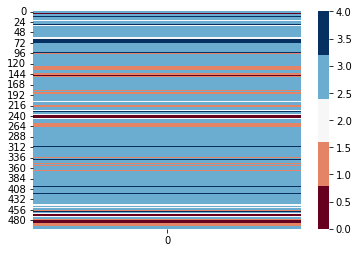

In [39]:
### first 500 time unit ###
cmap = plt.cm.get_cmap("RdBu", 5)
time_unit_500 = time_unit[:500]
time_unit_500_reshape = time_unit_500.reshape(-1,1)
# Create a heatmap of the data using the "viridis" colormap
sns.heatmap(time_unit_500_reshape, cmap=cmap)

# Display the heatmap
plt.show()

In [52]:
unique, counts_1000 = np.unique(time_unit_1000_reshape, return_counts=True)

# Print the unique elements and their counts
for i in range(len(unique)):
    print(f"{unique[i]}: {counts_1000[i]}")

0.0: 14
1.0: 49
2.0: 28
3.0: 359
4.0: 50


In [185]:
counts_1000

array([ 58,  57, 279, 106])

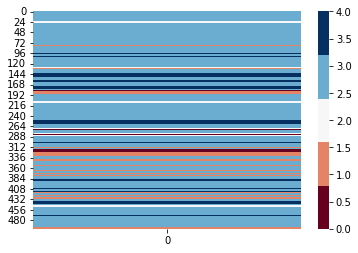

In [40]:
### 500-1000 time unit ###
cmap = plt.cm.get_cmap("RdBu", 5)
time_unit_1000 = time_unit[500:1000]
time_unit_1000_reshape = time_unit_1000.reshape(-1,1)
# Create a heatmap of the data using the "viridis" colormap
sns.heatmap(time_unit_1000_reshape, cmap=cmap)

# Display the heatmap
plt.show()

In [63]:
#plt.hist(time_unit_500_reshape)

In [51]:
unique, counts_1500 = np.unique(time_unit_1500_reshape, return_counts=True)

# Print the unique elements and their counts
for i in range(len(unique)):
    print(f"{unique[i]}: {counts_1500[i]}")

0.0: 2
1.0: 46
2.0: 34
3.0: 363
4.0: 55


In [188]:
counts_1500

array([ 51,  77, 159, 213])

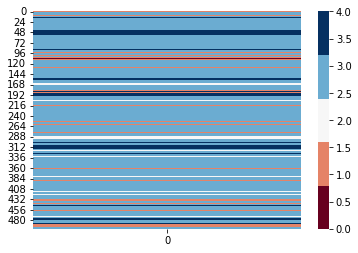

In [41]:
### first 1000-1500 time unit ###
cmap = plt.cm.get_cmap("RdBu", 5)
time_unit_1500 = time_unit[1000:1500]
time_unit_1500_reshape = time_unit_1500.reshape(-1,1)
# Create a heatmap of the data using the "viridis" colormap
sns.heatmap(time_unit_1500_reshape, cmap=cmap)

# Display the heatmap
plt.show()

In [50]:
unique_2000, counts_2000 = np.unique(time_unit_2000_reshape, return_counts=True)

# Print the unique elements and their counts
for i in range(len(unique_2000)):
    print(f"{unique_2000[i]}: {counts_2000[i]}")

0.0: 8
1.0: 28
2.0: 35
3.0: 382
4.0: 47


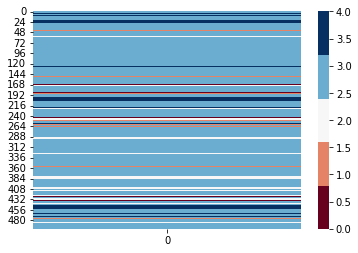

In [43]:
### first 1500-2000 time unit ###
cmap = plt.cm.get_cmap("RdBu", 5)
time_unit_2000 = time_unit[1500:2000]
time_unit_2000_reshape = time_unit_2000.reshape(-1,1)
# Create a heatmap of the data using the "viridis" colormap
sns.heatmap(time_unit_2000_reshape, cmap=cmap)

# Display the heatmap
plt.show()

In [49]:
unique_2500, counts_2500 = np.unique(time_unit_2500_reshape, return_counts=True)

# Print the unique elements and their counts
for i in range(len(unique_2500)):
    print(f"{unique_2500[i]}: {counts_2500[i]}")

0.0: 9
1.0: 72
2.0: 25
3.0: 347
4.0: 47


In [86]:
counts_2500

array([ 66,  35, 306,  93])

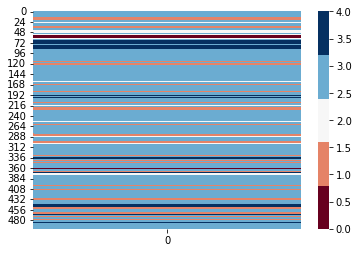

In [44]:
### first 2000-2500 time unit ###
cmap = plt.cm.get_cmap("RdBu", 5)
time_unit_2500 = time_unit[2000:2500]
time_unit_2500_reshape = time_unit_2500.reshape(-1,1)
# Create a heatmap of the data using the "viridis" colormap
sns.heatmap(time_unit_2500_reshape, cmap=cmap)

# Display the heatmap
plt.show()

In [48]:
unique_3000, counts_3000 = np.unique(time_unit_3000_reshape, return_counts=True)

# Print the unique elements and their counts
for i in range(len(unique_3000)):
    print(f"{unique_3000[i]}: {counts_3000[i]}")

0.0: 7
1.0: 46
2.0: 9
3.0: 380
4.0: 58


In [195]:
counts_3000

array([ 31,  32, 312, 125])

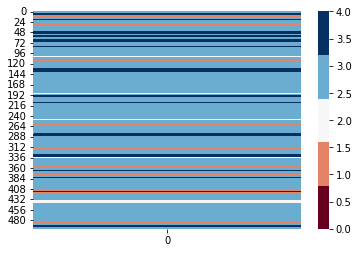

In [45]:
### first 2500-3000 time unit ###
cmap = plt.cm.get_cmap("RdBu", 5)
time_unit_3000 = time_unit[2500:3000]
time_unit_3000_reshape = time_unit_3000.reshape(-1,1)
# Create a heatmap of the data using the "viridis" colormap
sns.heatmap(time_unit_3000_reshape, cmap=cmap)

# Display the heatmap
plt.show()

In [47]:
unique_3384, counts_3384 = np.unique(time_unit_3384_reshape, return_counts=True)

# Print the unique elements and their counts
for i in range(len(unique_3384)):
    print(f"{unique_3384[i]}: {counts_3384[i]}")

0.0: 21
1.0: 40
2.0: 35
3.0: 242
4.0: 46


In [59]:
counts_3384

array([ 21,  40,  35, 242,  46])

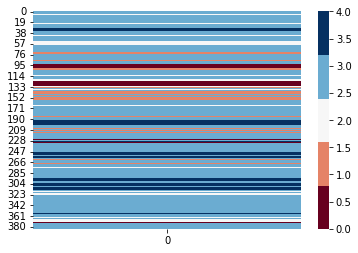

In [46]:
### first 3000-3384 time unit ###
cmap = plt.cm.get_cmap("RdBu", 5)
time_unit_3384 = time_unit[3000:3384]
time_unit_3384_reshape = time_unit_3384.reshape(-1,1)
# Create a heatmap of the data using the "viridis" colormap
sns.heatmap(time_unit_3384_reshape, cmap=cmap)

# Display the heatmap
plt.show()

In [67]:
#plt.hist(time_unit_1500_reshape)

In [108]:
a = (2,3,4,56,7)
np.shape(a)

(5,)

In [61]:
pause_trend = np.zeros(7)
counts = [counts_500[0], counts_1000[0], counts_1500[0], counts_2000[0], counts_2500[0], counts_3000[0], counts_3384[0]]
for i in range(len(counts)):
    pause_trend[i] = counts[i]
fixation_trend = np.zeros(7)
counts = [counts_500[1], counts_1000[1], counts_1500[1], counts_2000[1], counts_2500[1], counts_3000[1], counts_3384[1]]
for i in range(len(counts)):
    fixation_trend[i] = counts[i]
    
away_trend = np.zeros(7)
counts = [counts_500[2], counts_1000[2], counts_1500[2], counts_2000[2], counts_2500[2], counts_3000[2], counts_3384[2]]
for i in range(len(counts)):
    away_trend[i] = counts[i]
    
meno_trend = np.zeros(7)
counts = [counts_500[3], counts_1000[3], counts_1500[3], counts_2000[3], counts_2500[3], counts_3000[3], counts_3384[3]]
for i in range(len(counts)):
    meno_trend[i] = counts[i]   

stop_trend = np.zeros(7)
counts = [counts_500[4], counts_1000[4], counts_1500[4], counts_2000[4], counts_2500[4], counts_3000[4], counts_3384[4]]
for i in range(len(counts)):
    stop_trend[i] = counts[i]

In [62]:
fixation_trend

array([61., 49., 46., 28., 72., 46., 40.])

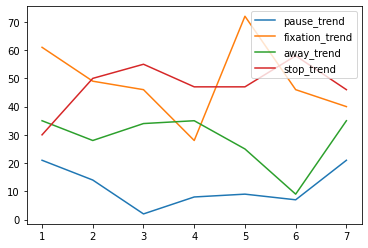

In [66]:
x = np.array([1, 2, 3, 4, 5, 6, 7])
y0 = np.array(pause_trend)
y1 = np.array(fixation_trend)
y2 = np.array(away_trend)
#y3 = np.array(meno_trend)
y4 = np.array(stop_trend)
plt.plot(x, y0, label="pause_trend")
plt.plot(x, y1, label="fixation_trend")
plt.plot(x, y2, label="away_trend")
#plt.plot(x, y3, label="meno_trend")
plt.plot(x, y4, label="stop_trend")
#plt.xlabel("X-axis label")
#plt.ylabel("Y-axis label")
#plt.title("Two lines plot")
plt.legend()
plt.show()

In [116]:
away_trend

array([47., 31., 34., 42., 32.,  9., 46.])

In [113]:
np.shape(fixation_trend)

(7,)

In [42]:
neural_movie = []
for t in time_unit:
    neural_m = neural[:,:,:,t]
    neural_movie.append(neural_m)
# neural_movie_ave = np.mean(neural_movie,axis = 0)
z = 25
for t in range(neural_movie.shape[-1]):
    plt.figure()
    plt.imshow(neural_movie[:,:,z,t].T)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [124]:
fixation_neural_movie = []
for t in fixation:
    pred_neural = neural[:,:,:,t-5:t]
    fixation_neural_movie.append(pred_neural)
fixation_neural_movie_ave = np.mean(fixation_neural_movie, axis = 0)
#plt.imshow(fixation_neural_movie_ave[:,:,20,])

In [125]:
fixation_neural_movie_ave.shape

(256, 128, 49, 5)

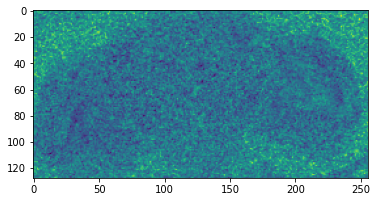

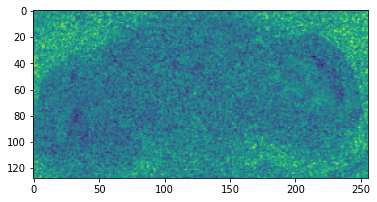

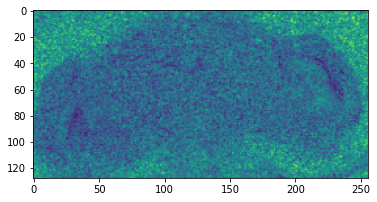

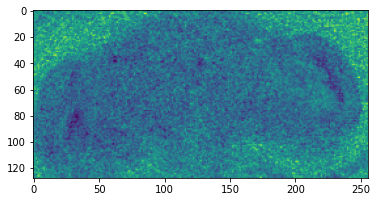

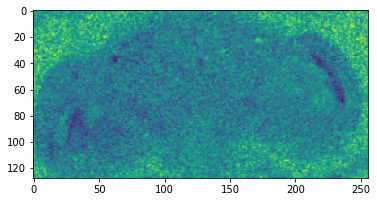

In [131]:
z = 25
for t in range(fixation_neural_movie_ave.shape[-1]):
    plt.figure()
    plt.imshow(fixation_neural_movie_ave[:,:,z,t].T)

In [97]:
a = neural[:,:,:,stop]

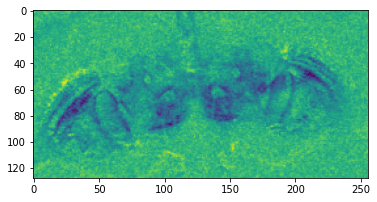

In [102]:
stop_average = a.mean(axis = -1)
plt.imshow(stop_average[:,:,10].T)

In [98]:
np.shape(a)

(256, 128, 49, 333)

In [38]:
neural_flat = neural.reshape(3384,-1)

In [39]:
np.shape(neural_flat )

(3384, 1605632)

In [59]:
bins = np.arange(-180,181,180)
all_slices = []
for z in range(49):
    #print(z)
    slice_neural = neural[:,:,z,:]
    
    heading_interpolated = interpolate_to_neural(z,timestamps)
    ### redefine 0
    heading_interpolated -= 180
    
    avg_neural_barposition = []
    bin_middle = []
    for i in range(len(bins)-1):
        start = bins[i]
        stop = bins[i+1]
        bin_middle.append((start+stop)/2)
        ids = np.where(np.logical_and(heading_interpolated>start, heading_interpolated<=stop))[0]
        avg_neural_barposition.append(np.mean(slice_neural[:,:,ids],axis=2))
    all_slices.append(np.asarray(avg_neural_barposition))
all_slices = np.asarray(all_slices)

In [81]:
np.shape(negative_bar_neural[15,0:80,0:128])

(80, 128)

In [61]:
negative_bar_neural = all_slices[:,0,:,:]
positive_bar_neural = all_slices[:,1,:,:]

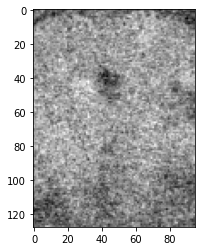

In [117]:
plt.imshow(positive_bar_neural[18,80:175,0:128].T, cmap='gray')
plt.show()

In [86]:
negative_bar_neural.reshape(49,-1)

array([[0.04733619, 0.05253727, 0.05807018, ..., 0.04681988, 0.05952482,
        0.03738071],
       [0.03283971, 0.05404504, 0.10066795, ..., 0.12210193, 0.1005967 ,
        0.03718472],
       [0.03102802, 0.06575885, 0.07305581, ..., 0.08242204, 0.10627069,
        0.05816987],
       ...,
       [0.04124533, 0.01932085, 0.05476721, ..., 0.07991333, 0.05955137,
        0.08000663],
       [0.03992916, 0.02181612, 0.06377196, ..., 0.06890018, 0.04388548,
        0.07635467],
       [0.08036512, 0.05543209, 0.05351071, ..., 0.05182005, 0.04616955,
        0.03471399]], dtype=float32)

In [46]:
bins

array([-180,  -90,    0,   90,  180])

In [121]:
np.shape(negative_bar_neural)

(49, 256, 128)

In [123]:
negative_neural_all = negative_bar_neural.reshape(49,-1)
positive_neural_all = positive_bar_neural.reshape(49,-1)

In [47]:
minus_lat_bar = all_slices[:,0,:,:]
minus_mid_bar = all_slices[:,1,:,:]
plus_lat_bar = all_slices[:,2,:,:]
plus_mid_bar = all_slices[:,3,:,:]

In [48]:
# Flatten the array to a 2D array with shape (49, 256 * 128)
minus_lat_flat = minus_lat_bar.reshape(49, -1)
minus_mid_flat = minus_mid_bar.reshape(49, -1)
plus_lat_flat = plus_lat_bar.reshape(49, -1)
plus_mid_flat = plus_mid_bar.reshape(49, -1)

In [49]:
np.shape(minus_lat_flat)

(49, 32768)

In [43]:
np.shape(all_signals)

(49, 2000, 3384)

In [44]:
all_signals_flat = all_signals.reshape(3384,-1)

In [45]:
np.shape(all_signals_flat )

(3384, 98000)

In [46]:
from sklearn.decomposition import PCA

In [47]:
# Perform PCA
pca = PCA(n_components=100)
pca.fit(all_signals_flat )

# Transform the data into the new feature space
# transformed_data = pca.transform(neural_flat)

# Visualize the results
# plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()

PCA(n_components=100)

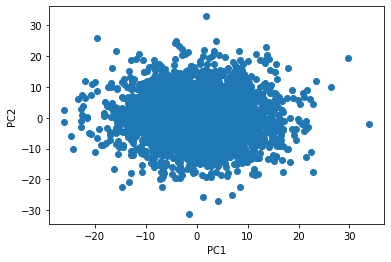

In [48]:
# Transform the data into the new feature space
transformed_data = pca.transform(all_signals_flat)

# Visualize the results
plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [49]:
print(pca.explained_variance_ratio_)

[0.00272549 0.00262421 0.00260421 0.00257094 0.00255359 0.00252322
 0.00248682 0.00246767 0.00245439 0.00243426 0.00236792 0.00232152
 0.00227653 0.00227322 0.00222994 0.00220093 0.00217841 0.0021717
 0.00215058 0.00214328 0.00208758 0.00208348 0.00206384 0.00204588
 0.00203586 0.00199391 0.00198287 0.00196829 0.00191856 0.00191522
 0.00184668 0.00183932 0.00181867 0.00179071 0.00176411 0.00174573
 0.00171495 0.00166904 0.00165015 0.00161948 0.00161236 0.00156546
 0.00154012 0.00151435 0.0015003  0.00146624 0.00143618 0.00140827
 0.00138665 0.00134918 0.00132066 0.0012822  0.0012592  0.00123869
 0.00121941 0.00117896 0.00116461 0.00112424 0.00111966 0.00107399
 0.00107277 0.00104375 0.00100868 0.00097131 0.00094837 0.00092149
 0.0008965  0.00087677 0.00085388 0.00083311 0.0008198  0.00081448
 0.00079734 0.00077723 0.00077405 0.00076882 0.00076609 0.00076456
 0.00075701 0.00075062 0.00074808 0.00073521 0.00072872 0.00071949
 0.00071738 0.00071572 0.0007114  0.00070728 0.00069968 0.00069

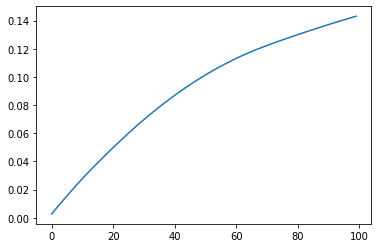

In [50]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [ ]:
############ Explode the brain #################


In [56]:
###########################
### PREP VISUAL STIMULI ###
###########################

vision_path = os.path.join(func_path, 'visual')
### Load Photodiode ###
t, ft_triggers, pd1, pd2 = brainsss.load_photodiode(vision_path)
stimulus_start_times = brainsss.extract_stim_times_from_pd(pd2, t)
### Unifrom the units and Make then intigers ###
stimulus_start_times = (stimulus_start_times*100).astype('int') #index needs to be an integers


####################
### Prep Fictrac ###
####################

fictrac_path = os.path.join(func_path, 'fictrac')
fictrac_raw = brainsss.load_fictrac(fictrac_path)


timestamps = brainsss.load_timestamps(os.path.join(func_path, 'imaging'))
fixed = brainsss.load_fda_meanbrain()


### GET 3384 RESOLUTION BEHAVIOR ###

fps = 100
resolution = 10 #desired resolution in ms
expt_len = fictrac_raw.shape[0]/fps*1000
behaviors = ['dRotLabY', 'dRotLabZ', 'heading']
fictrac = {}
for behavior in behaviors:
    if behavior == 'dRotLabY': short = 'Y'
    elif behavior == 'dRotLabZ': short = 'Z'
    elif behavior == 'heading': short = 'h'
    fictrac[short] = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,20])
    #fictrac[short] = np.roll(fictrac[short],400) # <------- misalignment is corrected !!!!!!
fictrac_timestamps = np.arange(0,expt_len,resolution)


loading photodiode data... done
Trying to load timestamp data from hdf5 file.
Success.


In [57]:
heading = fictrac['h']
heading = heading%360
heading

array([[0.69128892],
       [1.03040278],
       [5.63435479],
       ...,
       [5.47025246],
       [5.04951303],
       [0.        ]])

In [59]:
np.shape(corrs)

(98000,)

In [29]:
atlas = brainsss.load_roi_atlas()

explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas)

In [30]:
n_clusters = 2000
cluster_dir = os.path.join(func_path, 'clustering')

load_file = os.path.join(cluster_dir, 'cluster_labels.npy')
cluster_labels = np.load(load_file)

load_file = os.path.join(cluster_dir, 'cluster_signals.npy')
all_signals = np.load(load_file)

In [31]:
def supervoxel_to_full_res(brain, cluster_labels):
    n_clusters = brain.shape[1]
    
    reformed_brain = []
    for z in range(49):
        colored_by_betas = np.zeros((256*128))
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_labels[z,:]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = brain[z,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        reformed_brain.append(colored_by_betas)
    return np.asarray(reformed_brain)

### Luke's analysis
SV / all voxels -> PCA -> Take top 3 PC activities and correlate against locomotor velocities; get high variance explained form just a few PCs or high prediction of velocities from the PCs

### Yandan's analysis
- (data collected with visual stim) SV / all voxels -> PCA -> see how many PCS required for some proportion of variance (e.g. .5)
- (data collected without visual stim) Same thing
- Compare the PCs required

In [58]:
corrs = []
behavior = 'heading'
for z in range(49):
    fictrac_trace = brainsss.smooth_and_interp_fictrac(fictrac_raw, fps, resolution, expt_len, behavior, timestamps[:,z])
    # fictrac_trace_L = np.clip(fictrac_trace.flatten(),None,0)*-1 #only needed for Z that has +-.
    # shifted_beh = np.roll(fictrac['Y'][:,0],8) # mismatch of the time
    for voxel in range(2000):
        corrs.append(scipy.stats.pearsonr(all_signals[z,voxel,:], fictrac_trace.flatten())[0])

In [48]:
whole_corr = np.reshape(np.asarray(corrs),(49,2000))
whole_corr_reformed = supervoxel_to_full_res(whole_corr, cluster_labels)
STA_brain = np.swapaxes(whole_corr_reformed[np.newaxis,:,:,:],0,1)
# STA_brain.shape
warps_ZPOS = brainsss.warp_STA_brain(STA_brain=STA_brain, fly='fly_262', fixed=fixed, anat_to_mean_type='myr')

In [60]:
np.shape(corrs)

(98000,)

In [61]:
np.shape(neural)

(256, 128, 49, 3384)

In [62]:
np.shape(STA_brain)

(49, 1, 256, 128)

In [63]:
STA_brain_flat = STA_brain.reshape(1,-1)

In [67]:
np.shape(STA_brain_flat)

(1, 1605632)

In [68]:
# Perform PCA
pca = PCA(n_components=100)
pca.fit(STA_brain_flat)

# Transform the data into the new feature space
# transformed_data = pca.transform(neural_flat)

# Visualize the results
# plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.show()

ValueError: n_components=100 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

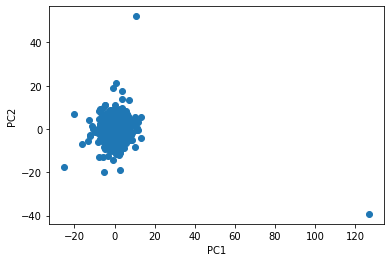

In [45]:
# Transform the data into the new feature space
transformed_data = pca.transform(all_signals_flat)

# Visualize the results
plt.scatter(transformed_data[:, 0], transformed_data[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [35]:
warp= brainsss.warp_STA_brain(out, fly = "fly_262", fixed=fixed, anat_to_mean_type = "myr")

In [47]:
np.save(savefile,warp)

In [36]:
np.shape(warp)

(14, 314, 146, 91)

In [42]:
func_path

'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_262/func_0/'

In [43]:
fly_path='/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_262/'

In [45]:
#os.mkdir(os.path.join(fly_path,'analysis'))

In [46]:
savefile = os.path.join(fly_path,'analysis',"20230516_warp_fixation")

In [30]:
np.shape(fixation_neural)

(256, 128, 49, 14)

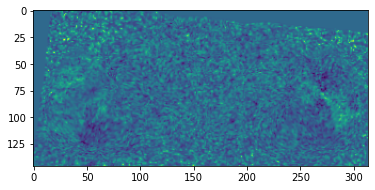

In [40]:
plt.imshow(np.mean(warp,axis =0)[:,:,50].T)

In [32]:
out = np.rollaxis(fixation_neural,3,0)
out = np.rollaxis(out,3,0)
out.shape

(49, 14, 256, 128)

In [48]:
np.shape(warp)

(14, 314, 146, 91)

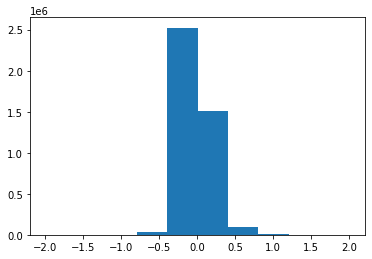

In [54]:
plt.hist(np.mean(warp,axis=0).flatten());

In [57]:
input_canvas = np.zeros((500,500,3)) #+.5 #.5 for diverging
data_to_plot = np.mean(warp,axis =0)[:,:,::-1]
vmax = .6
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                            roi_masks,
                                                            roi_contours,
                                                            data_to_plot,
                                                            input_canvas,
                                                            vmax=vmax,
                                                            cmap='seismic',
                                                            diverging=True)#'hot')

In [100]:
EB_mask = roi_masks[23]
masked_roi = EB_mask*warps_ZPOS[1,:,:,::-1]

TypeError: list indices must be integers or slices, not tuple

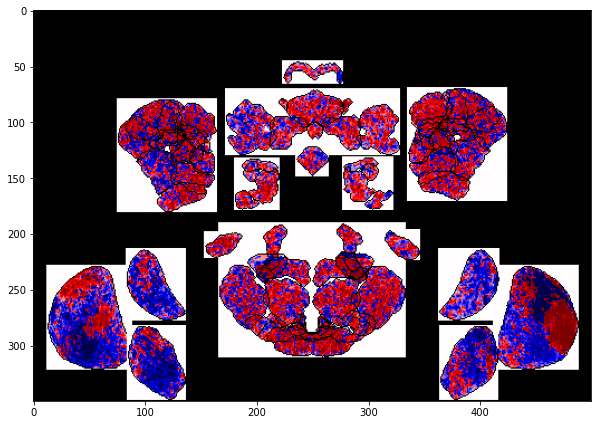

In [58]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])

In [26]:
roi_ids = brainsss.load_roi_hemi_ids()[0]

In [27]:
roi_ids

{'left': {3: 'LO_R',
  4: 'NO',
  5: 'BU_R',
  6: 'PB',
  7: 'LH_R',
  8: 'LAL_R',
  9: 'SAD',
  10: 'CAN_R',
  11: 'AMMC_R',
  12: 'ICL_R',
  13: 'VES_R',
  14: 'IB_R',
  15: 'ATL_R',
  16: 'CRE_R',
  17: 'MB_PED_R',
  18: 'MB_VL_R',
  19: 'MB_ML_R',
  20: 'FLA_R',
  22: 'LP_R',
  23: 'EB',
  24: 'AL_R',
  25: 'MED_R',
  26: 'FB',
  27: 'SLP_R',
  28: 'SIP_R',
  29: 'SMP_R',
  30: 'AVLP_R',
  31: 'PVLP_R',
  32: 'IVLP_R',
  33: 'PLP_R',
  34: 'AOTU_R',
  35: 'GOR_R',
  36: 'MB_CA_R',
  37: 'SPS_R',
  38: 'IPS_R',
  39: 'SCL_R',
  40: 'EPA_R',
  49: 'GNG',
  50: 'PRW'},
 'right': {4: 'NO',
  6: 'PB',
  9: 'SAD',
  23: 'EB',
  26: 'FB',
  49: 'GNG',
  50: 'PRW',
  53: 'LO_L',
  54: 'BU_L',
  55: 'LH_L',
  56: 'LAL_L',
  57: 'CAN_L',
  58: 'AMMC_L',
  59: 'ICL_L',
  60: 'VES_L',
  61: 'IB_L',
  62: 'ATL_L',
  63: 'CRE_L',
  64: 'MB_PED_L',
  65: 'MB_VL_L',
  66: 'MB_ML_L',
  67: 'FLA_L',
  69: 'LP_L',
  70: 'AL_L',
  71: 'MED_L',
  72: 'SLP_L',
  73: 'SIP_L',
  74: 'SMP_L',
  75: 'AVLP_L

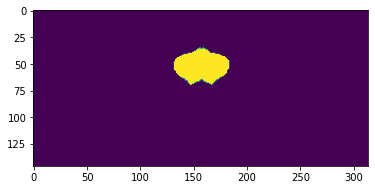

In [55]:
plt.imshow(np.max(roi_masks[26],axis=-1).T)

In [67]:
# Define cluster boundaries
fixation_range = (-20, 20)
away_ranges = [(-180, -160), (160, 180)]

# Initialize empty arrays for each cluster
fixation = []
away = []
rest = []

# Loop through each angle and categorize it
for t, angle in enumerate(heading.flatten()):
    if angle >= fixation_range[0] and angle <= fixation_range[1]:
        if np.abs(fwd[t])>stop_fwd_threshold or np.abs(ang[t])>stop_ang_threshold:
            fixation.append(t)
    elif angle >= away_ranges[0][0] and angle <= away_ranges[0][1]:
        if np.abs(fwd[t])>stop_fwd_threshold or np.abs(ang[t])>stop_ang_threshold:
            away.append(t)
    elif angle >= away_ranges[1][0] and angle <= away_ranges[1][1]:
        away.append(t)
    else:
        rest.append(t)

# Print the number of angles in each cluster
print(f"Fixation angles: {len(fixation)}")
print(f"Away angles: {len(away)}")
print(f"Rest angles: {len(rest)}")
# fixation, away, stop, and menotaxis are list of t (idex number in 3384)

stop_fwd_threshold = 0.5
stop_ang_threshold = 10
stop = []
menotaxis = []
for t in rest:
    if np.abs(fwd[t])<stop_fwd_threshold and np.abs(ang[t])<stop_ang_threshold:
        stop.append(t)
    else:
        menotaxis.append(t)
print(f"stop angles: {len(stop)}")  

Fixation angles: 5149
Away angles: 10295
Rest angles: 162606
stop angles: 20053


In [69]:
print(f"stop angles: {len(stop)}") 
print(f"menotaxis angles: {len(menotaxis)}") 

stop angles: 20053
menotaxis angles: 142553


In [101]:
np.shape(fixation)

(5149,)

In [73]:
a = np.asarray(fixation)

In [74]:
type(a)

numpy.ndarray

In [75]:
roi_traces = {}
for hemi in ['left', 'right']:
    roi_trace = brainsss.extract_roi_signal_traces(roi_ids,
                                                    roi_masks,
                                                    all_warps=warps_ZPOS,
                                                    condition=a,
                                                    hemi=hemi,
                                                    signal_type='mean')
    roi_traces[hemi] = roi_trace

TypeError: only integer scalar arrays can be converted to a scalar index

In [90]:
# negative_bar_neural[15,0:80,0:128] optic lobe
print(pca.explained_variance_ratio_)

[0.35098228 0.15524653]


In [93]:
# positive_bar_neural[15,0:80,0:128] left optic lobe
print(pca.explained_variance_ratio_)

[0.3509822  0.15524647]


In [98]:
# positive_bar_neural[20,176:256,0:128] right optic lobe
print(pca.explained_variance_ratio_)

[0.34816495 0.18164283]


In [104]:
# negative_bar_neural[20,176:256,0:128] right optic lobe
print(pca.explained_variance_ratio_)

[0.34816495 0.18164277]


In [116]:
#negative_bar_neural[18,80:175,0:128] central part
print(pca.explained_variance_ratio_)

[0.13942921 0.09745336]


In [119]:
# positive_bar_neural[18,80:175,0:128] central part
print(pca.explained_variance_ratio_)


[0.13942909 0.09745334]


In [125]:
# negative_neural_all
print(pca.explained_variance_ratio_)

[0.1793492  0.12035515]


In [127]:
# positive_neural_all
print(pca.explained_variance_ratio_)

[0.17964123 0.12108477]
